## Financial Fraud Detection Agentic Ai


* This code is a part of a machine learning pipeline that processes a dataset, performs exploratory data analysis (EDA), trains a decision tree classifier, makes predictions, evaluates the model, and suggests improvements if necessary.

* It uses the LangGraph library to define a state graph for the pipeline, with each step represented as a node in the graph.
* The pipeline starts by ingesting a dataset, followed by EDA, training the model, making predictions, evaluating the model's performance, and finally checking if retraining is needed based on the accuracy of the model.
* The final state of the pipeline is returned after invoking the pipeline with the initial state.

In [1]:
from langgraph.graph import StateGraph, START
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import json

In [2]:
from typing import TypedDict, Optional
from langgraph.graph import StateGraph

class AgentState(TypedDict, total=False):
    filepath: str
    df: pd.DataFrame
    model: RandomForestClassifier
    X_test: pd.DataFrame
    y_test: pd.Series
    predictions: list
    report: dict
    retrain: bool
    eda_done : bool

graph = StateGraph(AgentState)

In [4]:
#Initial State
initial_state = {
    "filepath": "PS_20174392719_1491204439457_log.csv"  # Change this to your dataset path
}

### 1. Ingestion Agent

In [5]:
def ingest_agent(state: AgentState):
    df = pd.read_csv(state['filepath'])
    state["df"] = df
    return state

### 2. EDA Agent

In [6]:
def eda_agent(state: AgentState):
    df = state["df"]
    #plt.figure(figsize=(6,6))
    #type_counts = df['type'].value_counts()
    #plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%')
    #plt.title("Transaction Type Distribution")
    #plt.show()

    plt.figure(figsize=(6,6))
    is_fraud_counts = df['isFraud'].value_counts()
    labels = [f"{'Non-Fraud' if label == 0 else 'Fraud'} ({count})" for label, count in is_fraud_counts.items()]
    plt.pie(is_fraud_counts, labels=labels, autopct='%1.1f%%')
    plt.title("Fraudulent Transaction Distribution")
    plt.show()

    state["eda_done"] = True
    return state

### 3. Model trainer Agent

In [8]:
from trainer import FraudModelTrainerAgent
trainer_agent = FraudModelTrainerAgent()

2025-06-15 22:26:46 - INFO - Trainer Agent initialized. Optuna Trials: 30, CV Folds: 3


### 4. Predictor Agent

In [15]:
def predict_agent(state: AgentState):
    clf = state["model"]
    X_test = state["X_test"]

    # Step 1: Get fraud probabilities (class 1)
    y_probs = clf.predict_proba(X_test)[:, 1]

    # Step 2: Apply custom threshold (e.g., 0.3)
    predictions = (y_probs > 0.3).astype(int)

    state["predictions"] = predictions
    print("Predictions made successfully.")
    return state

### 5. Evaluator Agent

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluation_agent(state: AgentState):
    y_true = state["y_test"]
    y_pred = state["predictions"]

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual non-fraud", "Actual fraud"], columns=["Predicted non-fraud", "Predicted fraud"])

    report = classification_report(y_true, y_pred, output_dict=True)

    # Calculate additional metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    plt.savefig("confusion_matrix.png")

    metrics = {
        'model_type': 'optimized_rf',
        'accuracy': report["accuracy"],
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'cv_scores_mean': state.get('cv_scores', []).mean(),
        'cv_scores_std': state.get('cv_scores', []).std()
    }
    
    # Save metrics to JSON
    with open('metrics_optimized_rf.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    
    return state

### Building the graph

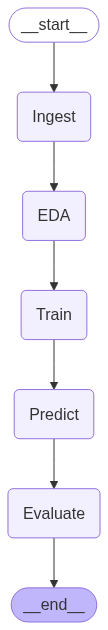

In [19]:
graph = StateGraph(AgentState)
graph.add_node("Ingest", ingest_agent)
graph.add_node("EDA", eda_agent)
graph.add_node("Train", trainer_agent.train_model)
graph.add_node("Predict", predict_agent)
graph.add_node("Evaluate", evaluation_agent)


graph.add_edge(START, "Ingest")
graph.add_edge("Ingest", "EDA")
graph.add_edge("EDA", "Train")
graph.add_edge("Train", "Predict")
graph.add_edge("Predict", "Evaluate")


#graph.set_entry_point(START)
graph.set_finish_point("Evaluate")
pipeline = graph.compile()

# Visualize the graph
#try block is initiated to attempt to execute some code that might raise an exception.
#Inside the try block, the display function is called with an Image object as its argument.
#The Image object is created with a PNG image generated by the draw_mermaid_png method of the get_graph method of graph.

from IPython.display import Image, display
try:
    display(Image(pipeline.get_graph().draw_mermaid_png()))
except Exception:
    pass

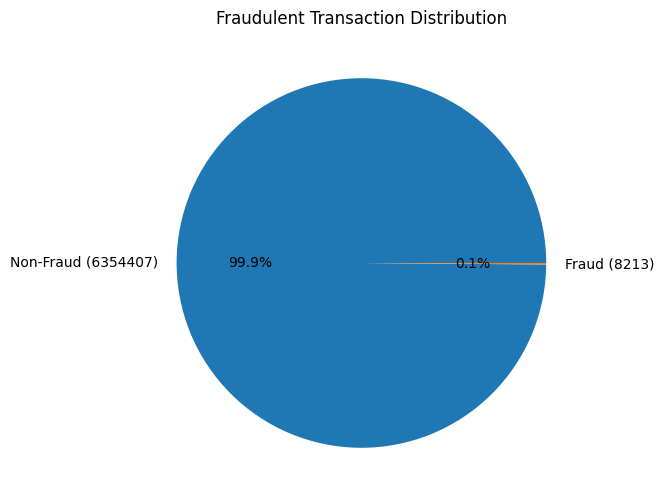

2025-06-15 18:00:57 - INFO - --- Starting Optimized Model Training Workflow ---
2025-06-15 18:00:58 - INFO - Optimizing memory usage...
2025-06-15 18:01:07 - INFO - Memory reduced from 1452.57 MB to 1331.21 MB (8.35% reduction)
2025-06-15 18:01:10 - INFO - Data split: 5090096 training samples, 1272524 testing samples.
2025-06-15 18:01:10 - INFO - Starting Optuna search for 30 trials (running in parallel)...
  0%|          | 0/30 [4:14:52<?, ?it/s]

[W 2025-06-15 22:16:03,336] Trial 10 failed with parameters: {'n_estimators': 243, 'max_depth': 18, 'min_samples_leaf': 15, 'min_samples_split': 8, 'max_features': 0.44837801575031405} because of the following error: KeyboardInterrupt().
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py", line 490, in _process_worker
    r = call_item()
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py", line 291, in __call__
    return self.fn(*self.args, **self.kwargs)
           ~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/parallel.py", line 607, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
            ~~~~^^^^^^^^^^^^^^^^^
 

KeyboardInterrupt: 

In [20]:
final_state = pipeline.invoke(initial_state)